# The pickup and delivery problem with transfers
By: Santiago Hincapie and Catalina Lesmes

## Pickup and delivery
The formulation we propose in this paper relies on the original PDP idea found in Desrochers et al. (1988), Desrosiers et al. (1995), Savelsbergh and Sol (1995). PDP can be conceptually described as finding the optimal way of assigning a set of transportation requests to a fleet of vehicles (initially located at several depots), by minimizing a specific purpose objective function, subject to a variety of constraints. The objective function may include components such  as operational costs, number of vehicles, customer’s level of service, and so on.

A transportation request consists of picking up a certain number of passengers from a predetermined pickup location and dropping them off at a predetermined delivery location.

the typical objective functions to be minimized are, in first place, the fleet size needed to satisfy the demand
with a determined level of service, and next, the total distance traveled by all vehicles, provided that the fleet size is fixed. In the case of passenger movements, instead of the distance attribute, a more reasonable objective function should include both the total waiting and travel time of all passengers, combined with some measure of the operational cost for running the system, weighted differently.

PDP constraints can be:
  * classified as visiting constraints (each pickup and delivery has to be visited exactly once)
  * vehicle capacity constraints
  * depot constraints 
  * coupling constraints (stating that for a given request the same vehicle must visit the pickup and delivery stops)
  * precedence constraints
  * resource constraints on the availability of drivers and vehicles
  * time window constraints to be satisfied at each stop, if time windows are explicitly defined

## Pickup and delivery with transfers
Let us describe the transfer point as a special object into the modeling context. In classical PDP, three kind of nodes can be distinguished: 
  * depots
  * origins 
  * destinations.
At every origin or destination node, we identify only  one operation associated with vehicles, which is either loading (origin) or unloading (destination) of passengers, but not both. At depots, actually there is no load/unload of passengers since vehicles start and finish their routes empty.

In the case of transfer nodes, vehicles may either load or unload passengers. To capture the difference between both operations, we propose to split every transfer node $r$, into two separate nodes, $s(r)$ (start node) and $f(r)$ (finish node), within which, only one operation associated with vehicles load/unload is allowed. When a vehicle passes through a transfer point $r$, it first enters node $s(r)$ to allow set down of passengers who wish to transfer to a different vehicle. The vehicle then proceeds (at least notionally) to node $f(r)$, where waiting passengers can get on board.

In [34]:
%%writefile example.pdpt
3
1 1 2
10 30 24
3 5
5
1 2 3
2 5 6
4 1 7
3 2 8
1 5 9
-
1 2 6
1 5 7
1 4 15
2 3 5
3 4 4
5 3 10

Overwriting example.pdpt


In [1]:
#%%writefile vehicle.py
class Vehicle:
    """Vehicle Class.
    
    This class store information about problem vehicles
    
    Attribuetes:
        time               (int): The actual time.
        position           (int): The vehicles actual position.
        capacity           (int): The vehicles actual capacity.
        limit              (int): The vehicles limit capacity.
        distance          (list): The distance travel.
    """
    def __init__(self, depost = None, limit = 0, request = []):
        """init method for PDPT class
        
        This method construct an PDPT instance
        
        Parameters:
            deposts  (list): The vehicle initial position
            limit   (tuple): The vehicle limit capacity
            request      (list): The request assign to this vehicle
        """
        self.time = 0
        self.position = depost
        self.requests = request
        self.limit = limit
        self.distance = 0

    def move(self, nx, cost):
        self.position = nx
        self.distance += cost
        delivery()

    def capacity(self):
        return sum([i[0] for i in self.requests])
    
    def endpoints(self):
        return [i[1] for i in self.requests]
            
    def pickup(self, value, destination):
        if value + self.capacity() < self.limit:
            self.requests.append((value, destination))
        else:
            value/0 # the ugliest way to generate an error
    
    def delivery(self):
        # https://stackoverflow.com/a/2522013/7929168 
        # why this instance try/except(ValueError)
        end = endpoints()
        while self.position in end: # if i can deliver
            pos = end.index(self.position)
            print("delivering {}".format(self.requests[pos]))
            del self.requests[pos]
                        
    def Transfer(self, other, request):
        index = self.requests.index(request)
        del self.requests[index]
        other.requests.append(request)
        
    def __rshift__(self, other):
        # Full transfer
        if self.capacity() + other.capacity() < other.limit:
            other.requests.extend(self.requests)
            self.requests = []
        else:
            self.requests.sort(key=lambda x: x[0], reverse=True)
            oc = other.capacity()
            while self.requests and self.requests[-1][0] + oc < other.limit:
                oc += self.requests[-1][0]
                other.requests.append(self.requests.pop())

    def __str__(self):
        return """
           o__________________
           |              |   \\
           |     cap {c}    |____\\_____
           | _____        |    |_o__ |
           [/ ___ \       |   / ___ \|
          []_/.-.\_\______|__/_/.-.\_[]
             |(O)|             |(O)|
              '-'   Pos {n}       '-'
        ---   ---   ---   ---   ---   --- 
        request : {req}
        """.format(c = self.limit,
                   n = self.position,
                   req = self.requests)

In [204]:
import networkx as nx
import matplotlib.pyplot as plt

class PDPT:
    """Pickup and delivery with Transfers Class.
    
    This class has the PDPT model.
    
    Attribuetes:
        N                  (int): The total numbers of vehicles in the instance.
        time               (int): The actual time.
        vehicles          (list): List of problem vehicles
        transfer_points  (tuple): Transfer Points
        requests          (dict): The Problem request
        origins          (tuple): The origin point for each request
        destinations     (tuple): The destination point for each request
        routes        (nx.Graph): The Graph with all the posible routes
    """
    
    def __init__(self, number_of_vehicles = 0, deposts = [], limit = [],
                 transfer_points = (), requests = {}, graph = None):
        """init method for PDPT class
        
        This method construct an PDPT instance
        
        Parameters:
            number_of_vehicles  (int): The total numbers of vehicles in the 
                                       instance.
            deposts            (list): The vehicles initial position, must have 
                                       a length of N
            limit             (tuple): The vehicles limit capacity, must have a
                                       length of N
            transfer_points   (tuple): Transfer Points
            requests           (dict): The Problem request
            graph          (nx.Graph): The Graph with all the posible routes
        """
        self.N = number_of_vehicles
        self.time = 0
        self.vehicles = []
        for i in range(self.N):
            self.vehicles.append(Vehicle(deposts[i], limit[i]))        
        self.transfer_points = transfer_points
        self.requests = requests
        self.origins = tuple(requests.keys())
        self.destinations = tuple(requests.values())
        self.routes = graph
    
    def solve(self, method = None, solution = None):
        """solver for PDPT instance
        
        Parameters:
            method      (str): the solution method
            solution  (tuple): initial solution
        
        Return:
            * Moves Matrix
            * total distance
        """
        path, dist = nx.floyd_warshall_predecessor_and_distance(self.routes)
        return
    
    def __str__(self):
        self.shoNonew()
        return '''This PDPT instance
        must to solve: {rq}
        The route trasfer points are {tra}
        '''.format(n = self.N, rq = self.requests,
                   tra = self.transfer_points)
    
    def show(self, pos = None, save = False): # TODO print graph
        positions = list(map(lambda x:x.position, self.vehicles))
        cact = list(set(self.routes.nodes()) - set(positions))
        if not pos:
            pos=nx.spring_layout(self.routes)
        nx.draw_networkx_nodes(self.routes, pos,
                               nodelist=cact,
                               node_size=500)
        nx.draw_networkx_nodes(self.routes, pos,
                              nodelist=positions,
                              node_size=500, node_color = 'g')
        nx.draw_networkx_edges(self.routes, pos, width=3)
        nx.draw_networkx_labels(self.routes, pos, font_size=15,
                                font_family='sans-serif')
        plt.axis('off')
        if save:
            name = input()
            plt.savefig(name + ".png")
        plt.show() 
    # def pretty_print(self, solution = None, method = ): TODO print_solution
    

def fromfile(path):
    with open(path,'r') as file:
        N = int(file.readline())
        deposts = list(map(int, file.readline().split()))
        limit = tuple(map(int, file.readline().split()))
        transfer_points = tuple(map(int, file.readline().split()))
        Nrequest = int(file.readline())
        requests = {}
        for i in range(Nrequest):
            ox, ex, wx = map(int, file.readline().split())
            aux = ex, wx
            if ox in requests:
                requests[ox].append(tuple(aux))
            else:
                requests[ox] = [tuple(aux)]
        file.readline()
        graph = file.read().split("\n")
        graph = nx.nx.parse_edgelist(graph, nodetype = int,
                                     data=(('weight',float),))
    return PDPT(number_of_vehicles = N,
               deposts = deposts, limit = limit,
               transfer_points = transfer_points,
               requests = requests, graph = graph)

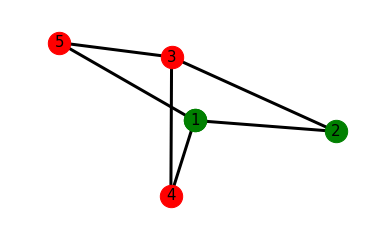

This PDPT instance
        must to solve: {1: [(2, 3), (5, 9)], 2: [(5, 6)], 3: [(2, 8)], 4: [(1, 7)]}
        The route trasfer points are (3, 5)
        
[[(2, 3), (5, 9)], [(5, 6)], [(2, 8)], [(1, 7)]]


In [265]:
self = fromfile(path="example.pdpt")
print(self)
print(self.destinations)

In [269]:
a = Vehicle(depost= 1, request=[(1, 2), (3, 1)], limit = 3)
b = Vehicle(depost= 2, request=[(3, 5)], limit= 7)

In [270]:
print(a)


           o__________________
           |              |   \
           |     cap 3    |____\_____
           | _____        |    |_o__ |
           [/ ___ \       |   / ___ \|
          []_/.-.\_\______|__/_/.-.\_[]
             |(O)|             |(O)|
              '-'   Pos 1       '-'
        ---   ---   ---   ---   ---   --- 
        request : [(1, 2), (3, 1)]
        


In [271]:
a >> b

In [272]:
print(a)


           o__________________
           |              |   \
           |     cap 3    |____\_____
           | _____        |    |_o__ |
           [/ ___ \       |   / ___ \|
          []_/.-.\_\______|__/_/.-.\_[]
             |(O)|             |(O)|
              '-'   Pos 1       '-'
        ---   ---   ---   ---   ---   --- 
        request : [(3, 1)]
        
